In [35]:
import pandas as pd 
import spacy

In [36]:
import re

In [3]:
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /mmfs1/home/mjilg/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
nlp = spacy.load("en_core_web_sm")

In [5]:
phab_path = "/mmfs1/gscratch/comdata/users/mjilg/mw-repo-lifecycles/case1/0217_ve_phab_comments.csv"
phab_df = pd.read_csv(phab_path)

In [7]:
#cleaning df 
phab_df['has_ref'] = phab_df['comment_text'].apply(lambda x: bool(re.search(r" visualeditor| VE | ve |VisualEditor", str(x), re.IGNORECASE)))
phab_df['has_bot_ref'] = phab_df['comment_text'].apply(lambda x: bool(re.search(r" bots | scripts | gadgets ", str(x), re.IGNORECASE)))
phab_df['timestamp'] = pd.to_datetime(phab_df['date_created'], unit='s', origin='unix', utc=True)
phab_df['comment_id'] = phab_df.index + 1
filtered_phab_df = phab_df[(phab_df['date_created'] < 1383264000) & (phab_df['date_created'] > 1351728000)]

In [8]:
#turning df into sentences 
sentence_level_data = filtered_phab_df.explode(
    'comment_text').reset_index(drop=True)

sentence_level_data['sentence'] = sentence_level_data['comment_text'].apply(
    lambda x: sent_tokenize(str(x)))

sentence_level_data = sentence_level_data.explode('sentence').reset_index(drop=True)

sentence_level_data['sentence_id'] = sentence_level_data.groupby('comment_id').cumcount() + 1

sentence_level_data = sentence_level_data.drop(columns=['has_bot_ref', 'has_ref'], errors='ignore')

sentence_level_data['has_ref'] = sentence_level_data['sentence'].apply(
    lambda x: bool(re.search(r'visualeditor| VE | ve |VisualEditor', x)))

sentence_level_data['has_bot_ref'] = sentence_level_data['sentence'].apply(
    lambda x: bool(re.search(r'bots|scripts|gadgets', x)))

sentence_level_data = sentence_level_data.reset_index(drop=True)


In [9]:
def extract_dependency_tree(sentence):
    doc = nlp(sentence)
    return [(token.text, token.dep_, token.head.text) for token in doc]

In [10]:
filtered_sentence_level_data = sentence_level_data[sentence_level_data['has_ref'] == True]

In [12]:
filtered_sentence_level_data['dependency_tree'] = filtered_sentence_level_data['sentence'].apply(extract_dependency_tree)


/tmp/ipykernel_88113/2706376531.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sentence_level_data['dependency_tree'] = filtered_sentence_level_data['sentence'].apply(extract_dependency_tree)


In [14]:
dependency_relations = []

for index, row in filtered_sentence_level_data.iterrows():
    sentence = row['sentence']
    timestamp = row['timestamp']
    comment_id = row['comment_id']
    sentence_id = row['sentence_id']
    
    for token, dep, head in row['dependency_tree']:
        if re.search(r'visualeditor|VE|ve|VisualEditor', token, re.IGNORECASE):
            dependency_relations.append({
                'sentence_id': sentence_id,
                'comment_id': comment_id,
                'timestamp': timestamp,
                'token': token,
                'dependency': dep,
                'head': head
            })
            
dependency_relations_df = pd.DataFrame(dependency_relations)

In [15]:
dependency_relations_df

sentence_id  comment_id                 timestamp         token  \
0               1         725 2013-10-03 20:15:00+00:00       ve.base   
1               1         725 2013-10-03 20:15:00+00:00          have   
2               1         725 2013-10-03 20:15:00+00:00  VisualEditor   
3               1         747 2013-09-28 15:44:00+00:00            VE   
4               5         750 2013-09-30 23:29:57+00:00  VisualEditor   
...           ...         ...                       ...           ...   
5744            2       32259 2013-10-06 23:34:50+00:00      autosave   
5745            2       32259 2013-10-06 23:34:50+00:00            VE   
5746            2       32330 2013-04-28 17:25:19+00:00            VE   
5747            7       32338 2013-03-06 06:29:37+00:00  VisualEditor   
5748            7       32338 2013-03-06 06:29:37+00:00          have   

     dependency      head  
0          pobj       for  
1           aux  switched  
2     nsubjpass    broken  
3          pobj        of  
4         nsubj  switched  
...         ...       ...  
5744      advcl     allow  
5745       pobj        in  
5746       dobj  enabling  
5747       pobj        in  
5748      advcl  minified  

[5749 rows x 6 columns]

In [18]:
pattern = r'\b(ve|VE|visualeditor|VisualEditor)\b'
filtered_dependencies = dependency_relations_df[dependency_relations_df['token'].str.contains(pattern, regex=True)]

/tmp/ipykernel_88113/3477839074.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_dependencies = dependency_relations_df[dependency_relations_df['token'].str.contains(pattern, regex=True)]


In [19]:
filtered_dependencies

sentence_id  comment_id                 timestamp         token  \
0               1         725 2013-10-03 20:15:00+00:00       ve.base   
2               1         725 2013-10-03 20:15:00+00:00  VisualEditor   
3               1         747 2013-09-28 15:44:00+00:00            VE   
4               5         750 2013-09-30 23:29:57+00:00  VisualEditor   
5               3         752 2013-09-30 07:16:14+00:00            VE   
...           ...         ...                       ...           ...   
5742            5       32251 2013-10-08 21:22:02+00:00  VisualEditor   
5743            2       32259 2013-10-06 23:34:50+00:00            VE   
5745            2       32259 2013-10-06 23:34:50+00:00            VE   
5746            2       32330 2013-04-28 17:25:19+00:00            VE   
5747            7       32338 2013-03-06 06:29:37+00:00  VisualEditor   

     dependency      head  
0          pobj       for  
2     nsubjpass    broken  
3          pobj        of  
4         nsubj  switched  
5         nsubj     being  
...         ...       ...  
5742       poss      take  
5743      nsubj  autosave  
5745       pobj        in  
5746       dobj  enabling  
5747       pobj        in  

[3579 rows x 6 columns]

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

/tmp/ipykernel_88113/2718119808.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax0.set_xticklabels(ax0.get_xticklabels(), rotation=45)
/tmp/ipykernel_88113/2718119808.py:17: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  filtered_dependencies['week'] = filtered_dependencies['timestamp'].dt.to_period('W').dt.start_time
/tmp/ipykernel_88113/2718119808.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dependencies['week'] = filtered_dependencies['timestamp'].dt.to_period('W').dt.start_time
/tmp/ipykernel_88113/2718119808.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of tick

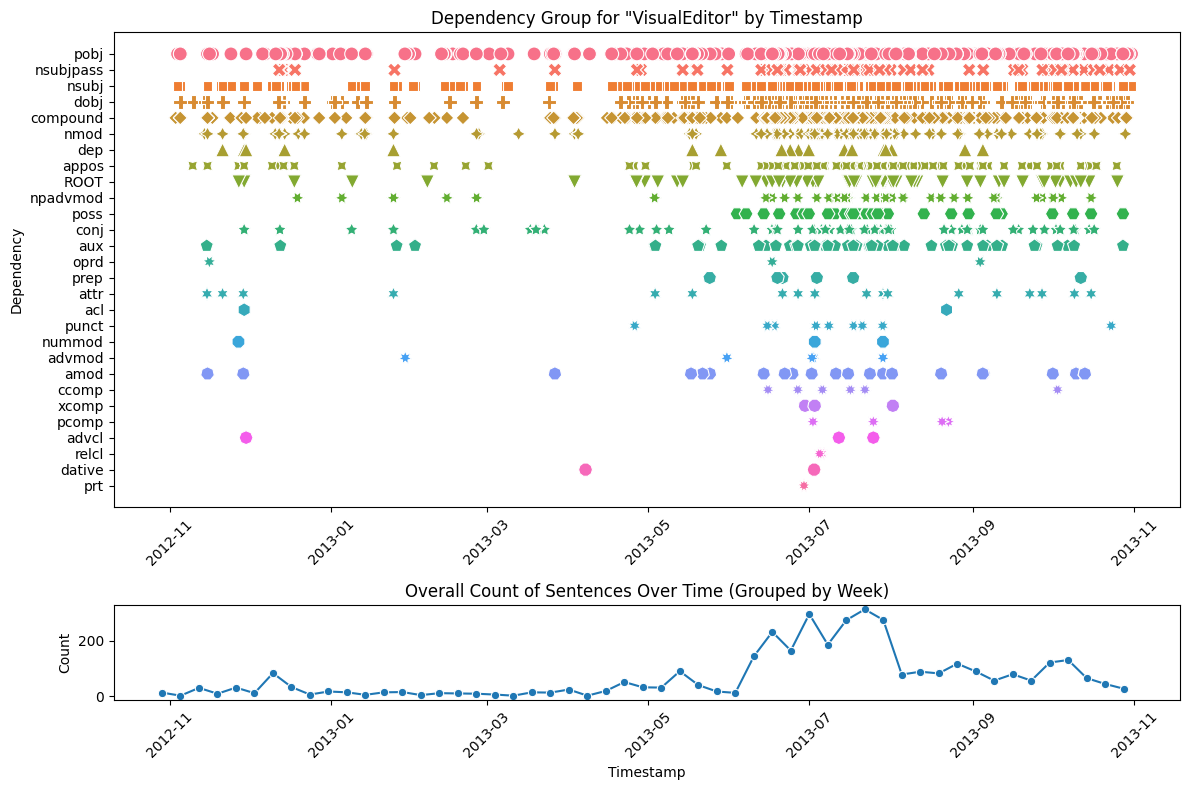

In [46]:
plt.figure(figsize=(12, 8))
gs = GridSpec(2, 1, height_ratios=[5, 1])

# Main plot: Dependency groups by timestamp
ax0 = plt.subplot(gs[0])
sns.scatterplot(data=filtered_dependencies, x='timestamp', y='dependency', hue='dependency', style='dependency', markers=True, s=100, ax=ax0)
ax0.set_title('Dependency Group for "VisualEditor" by Timestamp')
ax0.set_xticklabels(ax0.get_xticklabels(), rotation=45)
#ax0.set_xticklabels([])
ax0.set_xlabel('')
ax0.set_ylabel('Dependency')
#ax0.legend(title='Dependency', bbox_to_anchor=(1, 1), loc='upper left')
ax0.legend().set_visible(False)

# Secondary plot: Overall count of sentences over time
ax1 = plt.subplot(gs[1], sharex=ax0)
filtered_dependencies['week'] = filtered_dependencies['timestamp'].dt.to_period('W').dt.start_time
weekly_counts = filtered_dependencies['week'].value_counts().sort_index()
sns.lineplot(x=weekly_counts.index, y=weekly_counts.values, ax=ax1, marker='o')
ax1.set_title('Count of Sentences Discussing VE (Grouped by Week)')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Count')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [39]:
bot_filtered_sentence_level_data = sentence_level_data[sentence_level_data['has_bot_ref'] == True]
bot_filtered_sentence_level_data['dependency_tree'] = bot_filtered_sentence_level_data['sentence'].apply(extract_dependency_tree)

/tmp/ipykernel_88113/123644997.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bot_filtered_sentence_level_data['dependency_tree'] = bot_filtered_sentence_level_data['sentence'].apply(extract_dependency_tree)


In [41]:
bot_dependency_relations = []

for index, row in bot_filtered_sentence_level_data.iterrows():
    sentence = row['sentence']
    timestamp = row['timestamp']
    comment_id = row['comment_id']
    sentence_id = row['sentence_id']
    
    for token, dep, head in row['dependency_tree']:
        if re.search(r'bots|scripts|gadgets', token, re.IGNORECASE):
            bot_dependency_relations.append({
                'sentence_id': sentence_id,
                'comment_id': comment_id,
                'timestamp': timestamp,
                'token': token,
                'dependency': dep,
                'head': head
            })
            
bot_dependency_relations_df = pd.DataFrame(bot_dependency_relations)

/tmp/ipykernel_88113/1174763112.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax0.set_xticklabels(ax0.get_xticklabels(), rotation=45)
/tmp/ipykernel_88113/1174763112.py:17: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  bot_dependency_relations_df['week'] = bot_dependency_relations_df['timestamp'].dt.to_period('W').dt.start_time
/tmp/ipykernel_88113/1174763112.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


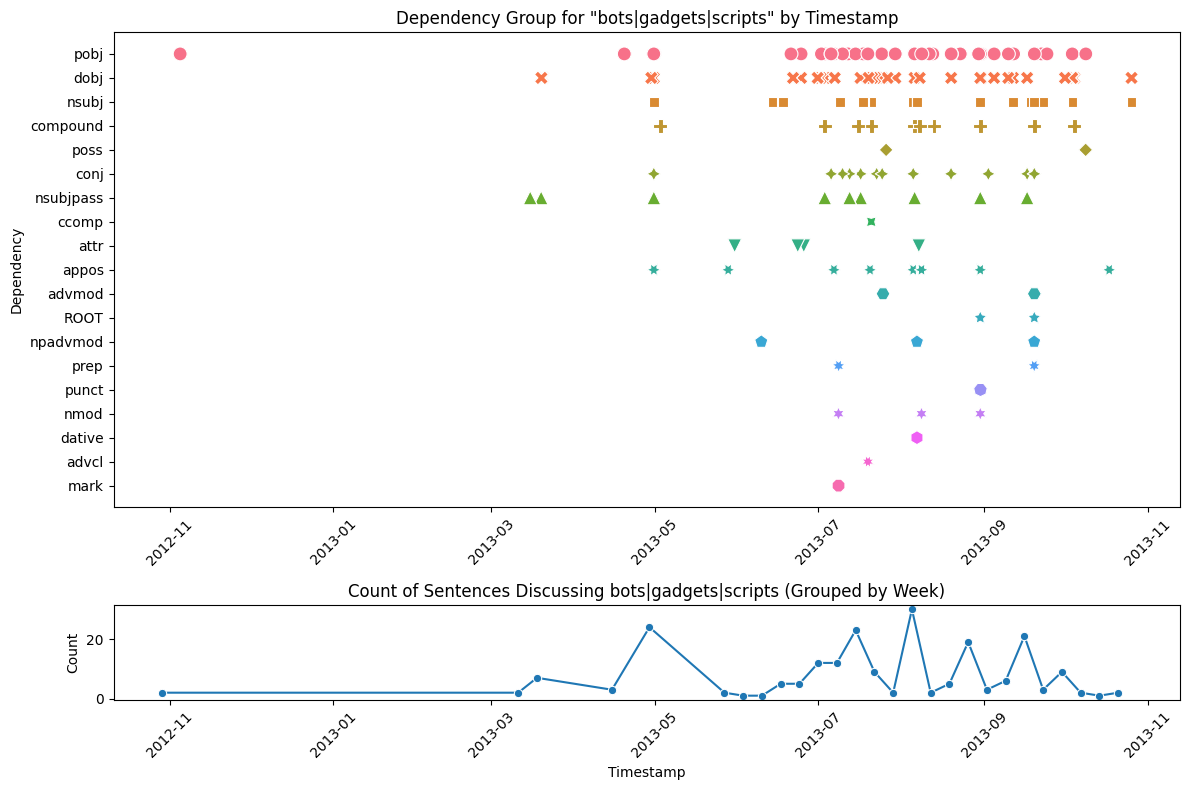

In [44]:
plt.figure(figsize=(12, 8))
gs = GridSpec(2, 1, height_ratios=[5, 1])

# Main plot: Dependency groups by timestamp
ax0 = plt.subplot(gs[0])
sns.scatterplot(data=bot_dependency_relations_df, x='timestamp', y='dependency', hue='dependency', style='dependency', markers=True, s=100, ax=ax0)
ax0.set_title('Dependency Group for "bots|gadgets|scripts" by Timestamp')
ax0.set_xticklabels(ax0.get_xticklabels(), rotation=45)
#ax0.set_xticklabels([])
ax0.set_xlabel('')
ax0.set_ylabel('Dependency')
#ax0.legend(title='Dependency', bbox_to_anchor=(1, 1), loc='upper left')
ax0.legend().set_visible(False)

# Secondary plot: Overall count of sentences over time
ax1 = plt.subplot(gs[1], sharex=ax0)
bot_dependency_relations_df['week'] = bot_dependency_relations_df['timestamp'].dt.to_period('W').dt.start_time
weekly_counts = bot_dependency_relations_df['week'].value_counts().sort_index()
sns.lineplot(x=weekly_counts.index, y=weekly_counts.values, ax=ax1, marker='o')
ax1.set_title('Count of Sentences Discussing bots|gadgets|scripts (Grouped by Week)')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Count')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()